In [1]:
from TFM import LlamaPredictor
import torch
from utils import torch_data, shuffle, blogm, bSqc, Neg, Sa, eps, create_train_test_split, save_checkpoint, load_checkpoint, save_checkpoint_and_test
from math import prod

dtype = torch.complex128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-02 05:35:07.495512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754112907.505493    7108 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754112907.510858    7108 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754112907.517819    7108 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00

In [2]:
train_size = 78*10**6
test_size = 10**6
batch = 1000
N = 36
d = 5
file = 'save'

checkpoint_epoch_pairs = [(19,19),(0,0),(19,0)]
with torch.no_grad():
    for theta_idx in range(11):
        # load model
        mdl = LlamaPredictor(L_max=N,
                            d=d,
                            n_embd=96, 
                            n_layer=36, 
                            n_head=48,
                            vocab_size=3, 
                            dropout_prob=0.0).to(device)
        optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-4)

        # load data
        prepseq_all = torch.load(f'data/theta{theta_idx}/all_prepseq_theta={theta_idx}.pt',weights_only=True)
        shadow_all = torch.load(f'data/theta{theta_idx}/all_shadow_state_theta={theta_idx}.pt',weights_only=True)
        rhoS_all = torch.load(f'data/theta{theta_idx}/all_rhoS_theta={theta_idx}.pt',weights_only=True)
        
        # Preprocess all prepseq data once (add 1 and append zero column)
        prepseq_all = torch.cat([prepseq_all+1, torch.zeros(prepseq_all.shape[0], 1, dtype=prepseq_all.dtype)], -1)
        
        # Create non-overlapping train/test split with batching
        train_data, test_data = create_train_test_split(
            prepseq_all, shadow_all, rhoS_all, 
            train_size, test_size, batch
        )
        
        # Extract batched data for convenience
        prepseq_train = train_data['prepseq']
        shadow_state_train = train_data['shadow_state']
        rhoS_train = train_data['rhoS']
        
        prepseq_test = test_data['prepseq'].to(device)
        shadow_state_test = test_data['shadow_state'].to(device)
        rhoS_test = test_data['rhoS'].to(device)

        torch.save(rhoS_test.view(-1, 4, 4), f'test_records/rhoS_theta={theta_idx}_test.pt')

        for pairs in checkpoint_epoch_pairs:
            checkpoint, epoch = pairs
            # load checkpoint model
            checkpoint_info = load_checkpoint(mdl, optimizer, epoch, checkpoint, 
                                                    save_dir=f'{file}/models', 
                                                    filename_prefix=f'model_d{d}_theta_idx{theta_idx}')
            print(f"loaded checkpoint {checkpoint} from epoch {epoch}")
            # run test loop
            mdl.eval()
            rhoC_test = []
            test_batches = prepseq_test.shape[0]
            for j in range(test_batches):
                prepseq_batch = prepseq_test[j].to(device)
                shadow_state_batch = shadow_state_test[j].to(device) 
                rhoS_batch = rhoS_test[j].to(device)
                rhoC = mdl(prepseq_batch, False)
                rhoC_test.append(rhoC)
            rhoC_test = torch.stack(rhoC_test).view(-1, 4, 4).to(device)
            torch.save(rhoC_test, f'test_records/rhoC_theta={theta_idx}_checkpoint={checkpoint}_epoch={epoch}.pt')
            # calculate mean and second moment of Sqc, Neg, Sa, loss
            Sqc = bSqc(rhoS_test.view(-1, 4, 4), rhoC_test)
            neg = Neg(rhoS_test.view(-1, 4, 4), rhoC_test)
            sa = Sa(rhoS_test.view(-1, 4, 4), rhoC_test)
            # save results
            torch.save(Sqc, f'test_records/Sqc_theta={theta_idx}_checkpoint={checkpoint}_epoch={epoch}.pt')
            torch.save(neg, f'test_records/neg_theta={theta_idx}_checkpoint={checkpoint}_epoch={epoch}.pt')
            torch.save(sa, f'test_records/sa_theta={theta_idx}_checkpoint={checkpoint}_epoch={epoch}.pt')
            # calculate loss
            rhoC_test = []
            for j in range(test_batches):
                prepseq_batch = prepseq_test[j].to(device)
                shadow_state_batch = shadow_state_test[j].to(device) 
                rhoS_batch = rhoS_test[j].to(device)
                rhoC = mdl(prepseq_batch, True)
                rhoC_test.append(rhoC)
            rhoC_test = torch.stack(rhoC_test).view(-1, 4, 4).to(device)
            loss = -torch.bmm(torch.bmm(shadow_state_test.view(-1, 4).conj().unsqueeze(1), rhoC_test), shadow_state_test.view(-1, 4).unsqueeze(-1)).view(-1).real.log()
            torch.save(loss, f'test_records/loss_theta={theta_idx}_checkpoint={checkpoint}_epoch={epoch}.pt')
            print(f'test at epoch {epoch} checkpoint {checkpoint} complete:')
            print(f'Sqc mean: {Sqc.sum().item()/test_size:.4f}, second moment: {(Sqc**2).sum().item()/test_size:.4f}')
            print(f'Neg mean: {neg.sum().item()/test_size:.4f}, second moment: {(neg**2).sum().item()/test_size:.4f}')
            print(f'Sa mean: {sa.sum().item()/test_size:.4f}, second moment: {(sa**2).sum().item()/test_size:.4f}')
            print(f'loss mean: {loss.sum().item()/test_size:.4f}, second moment: {(loss**2).sum().item()/test_size:.4f}')

test size=1000000, train size=78000000
test indices: [0-999999], train indices: [1000000-78999999]
Checkpoint loaded: save/models/model_d5_theta_idx0_epoch0019_step0019.pt
loaded checkpoint 19 from epoch 19
test at epoch 19 checkpoint 19 complete:
Sqc mean: 0.2399, second moment: 15.2336
Neg mean: 0.0000, second moment: 0.0000
Sa mean: 0.1079, second moment: 7.5882
loss mean: 1.0577, second moment: 1.6372
Checkpoint loaded: save/models/model_d5_theta_idx0_epoch0000_step0000.pt
loaded checkpoint 0 from epoch 0
test at epoch 0 checkpoint 0 complete:
Sqc mean: 0.2578, second moment: 18.3340
Neg mean: -0.0084, second moment: 0.4637
Sa mean: 0.1099, second moment: 7.8385
loss mean: 1.0601, second moment: 1.6445
Checkpoint loaded: save/models/model_d5_theta_idx0_epoch0000_step0019.pt
loaded checkpoint 19 from epoch 0
test at epoch 0 checkpoint 19 complete:
Sqc mean: 0.2418, second moment: 16.3110
Neg mean: -0.0000, second moment: 0.0021
Sa mean: 0.1085, second moment: 7.6626
loss mean: 1.058

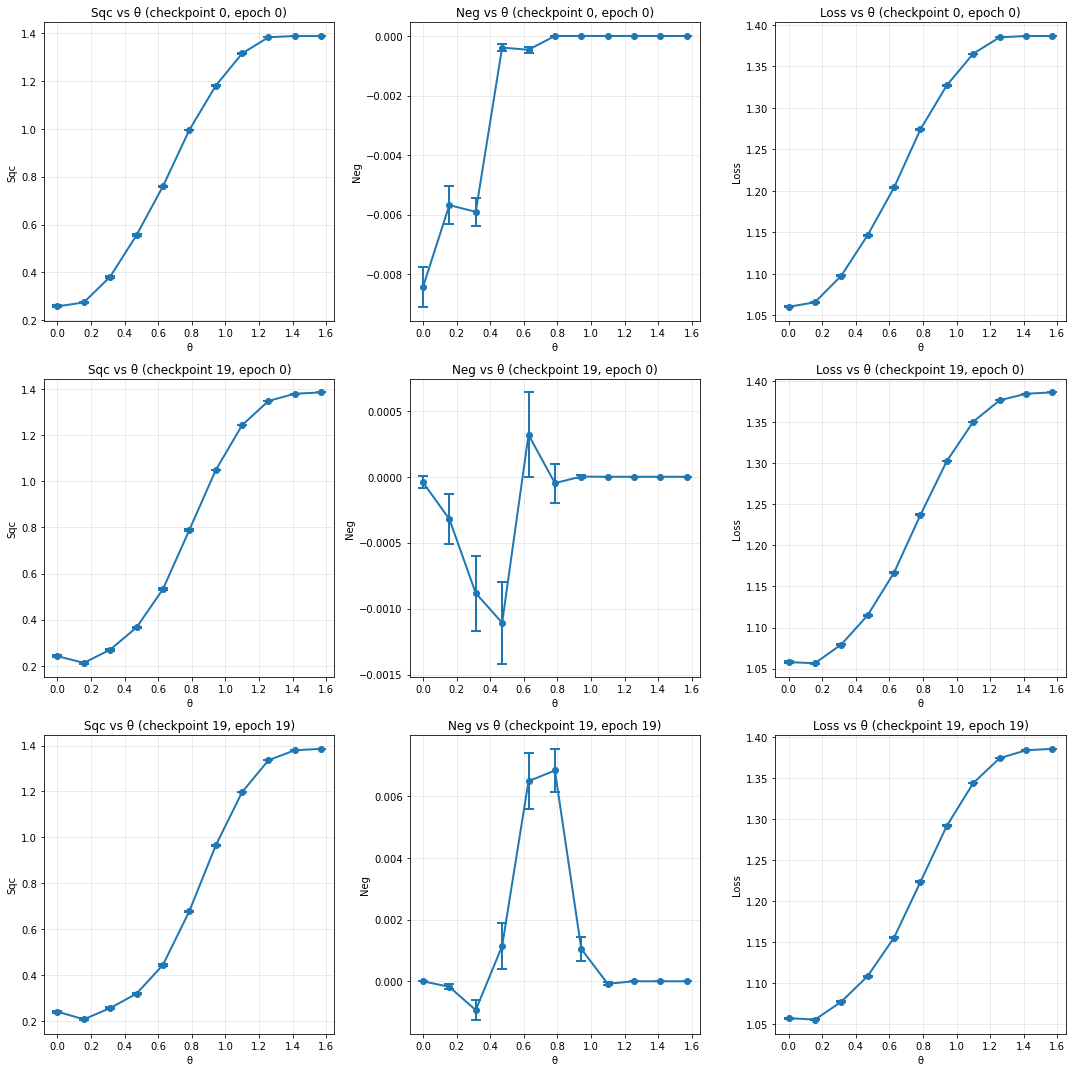

In [4]:
# Plot with error bar for each checkpoint
import torch
import matplotlib.pyplot as plt
import numpy as np

checkpoint_epoch_pairs = [(0,0),(19,0),(19,19)]  # Add more pairs as needed

# Create subplot grid: rows = checkpoints, columns = [Sqc, Neg, Loss]
n_checkpoints = len(checkpoint_epoch_pairs)
fig, axes = plt.subplots(nrows=n_checkpoints, ncols=3, figsize=(15, 5*n_checkpoints))

# If only one checkpoint, ensure axes is 2D
if n_checkpoints == 1:
    axes = axes.reshape(1, -1)

# Theta values for x-axis
theta_values = torch.linspace(0, torch.pi/2, 11)

for row, pairs in enumerate(checkpoint_epoch_pairs):
    checkpoint, epoch = pairs
    
    # Initialize lists to store data for all theta values
    Sqc_means, Sqc_stds = [], []
    Neg_means, Neg_stds = [], []
    loss_means, loss_stds = [], []
    
    # Collect data for all theta values
    for theta in range(0, 11):
        # Load data
        Sqc_test = torch.load(f'test_records/Sqc_theta={theta}_checkpoint={checkpoint}_epoch={epoch}.pt')
        Neg_test = torch.load(f'test_records/neg_theta={theta}_checkpoint={checkpoint}_epoch={epoch}.pt')
        loss_test = torch.load(f'test_records/loss_theta={theta}_checkpoint={checkpoint}_epoch={epoch}.pt')
        
        # Compute mean and standard error
        Sqc_mean = Sqc_test.mean().item()
        Sqc_std = ((Sqc_test**2).mean() - Sqc_mean**2).sqrt().item() / (Sqc_test.numel()**0.5)
        
        Neg_mean = Neg_test.mean().item()
        Neg_std = ((Neg_test**2).mean() - Neg_mean**2).sqrt().item() / (Neg_test.numel()**0.5)
        
        loss_mean = loss_test.mean().item()
        loss_std = ((loss_test**2).mean() - loss_mean**2).sqrt().item() / (loss_test.numel()**0.5)
        
        # Store results
        Sqc_means.append(Sqc_mean)
        Sqc_stds.append(Sqc_std)
        Neg_means.append(Neg_mean)
        Neg_stds.append(Neg_std)
        loss_means.append(loss_mean)
        loss_stds.append(loss_std)
    
    # Plot Sqc vs theta (column 0)
    axes[row, 0].errorbar(theta_values, Sqc_means, yerr=Sqc_stds, 
                         marker='o', capsize=5, capthick=2, linewidth=2)
    axes[row, 0].set_xlabel('θ')
    axes[row, 0].set_ylabel('Sqc')
    axes[row, 0].set_title(f'Sqc vs θ (checkpoint {checkpoint}, epoch {epoch})')
    axes[row, 0].grid(True, alpha=0.3)
    
    # Plot Neg vs theta (column 1)
    axes[row, 1].errorbar(theta_values, Neg_means, yerr=Neg_stds, 
                         marker='o', capsize=5, capthick=2, linewidth=2)
    axes[row, 1].set_xlabel('θ')
    axes[row, 1].set_ylabel('Neg')
    axes[row, 1].set_title(f'Neg vs θ (checkpoint {checkpoint}, epoch {epoch})')
    axes[row, 1].grid(True, alpha=0.3)
    
    # Plot Loss vs theta (column 2)
    axes[row, 2].errorbar(theta_values, loss_means, yerr=loss_stds, 
                         marker='o', capsize=5, capthick=2, linewidth=2)
    axes[row, 2].set_xlabel('θ')
    axes[row, 2].set_ylabel('Loss')
    axes[row, 2].set_title(f'Loss vs θ (checkpoint {checkpoint}, epoch {epoch})')
    axes[row, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()